<a href="https://colab.research.google.com/github/Kabongosalomon/Introduction-RL/blob/master/Session%2001/AIMS_2020_Exercice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning in Finite Markov Decision Processes MDP)ss

In [1]:
!git clone https://github.com/Kabongosalomon/Introduction-RL.git > /dev/null 2>&1
!cd Introduction-RL && git pull

Already up to date.


## MDPs

In [0]:
import sys
sys.path.insert(0, './Introduction-RL/tools/utils')
import numpy as np
import matplotlib.pyplot as plt
import json
import math
from gridworld import GridWorldWithPits

## Define the environment

In [0]:
from finite_env import FiniteEnv
import numpy as np

class RobotEnv(FiniteEnv):
    """
    Enviroment with 2 states and 3 actions
    Args:
        gamma (float): discount factor
        seed    (int): Random number generator seed
    """

    def __init__(self, gamma=0.5, seed=42):
        # Set seed
        self.RS = np.random.RandomState(seed)

        # Transition probabilities
        # shape (Ns, Na, Ns)
        # P[s, a, s'] = Prob(S_{t+1}=s'| S_t = s, A_t = a)

        Ns = 2
        Na = 3
        
        # P = np.array([[[1, 0], [3/4, 1/4], [1, 0]], [[0,1],[1,0], [1,0]]])      # |SxAxS|
        P = np.array([[[1, 0], [3/4, 1/4], [0, 0]], [[0,1],[1,0], [1,0]]]) 

        self._R = np.array([[0,1,-0.5], [0, -1, 0]])                            # |SxA|

        self.state_decoder  = {0: "A", 1: "B"}
        self.action_decoder = {0: "WAIT", 1: "SEARCH", 2: "RECHARGE"}
        
        # Initialize base class
        states = np.arange(Ns).tolist()
        action_sets = [np.arange(Na).tolist()]*Ns
        super().__init__(states, action_sets, P, gamma)

    def reward_func(self, state, action, *_):
        return self._R[state, action]

    def reset(self, s=0):
        self.state = s
        return self.state

    def step(self, action):
        next_state = self.sample_transition(self.state, action)
        reward = self.reward_func(self.state, action, next_state)
        done = False
        info = {"str" : "In {} do {} arrive at {} get {}".format(
            self.state_decoder[state],
            self.action_decoder[action],
            self.state_decoder[next_state],
            reward )}
        self.state = next_state

        observation = next_state
        return observation, reward, done, info

    def sample_transition(self, s, a):
        prob = self.P[s,a,:]
        s_ = self.RS.choice(self.states, p = prob)
        return s_

    def render_policy(self, policy):
      if len(np.array(policy).shape) > 1:
        policy = densify_policy(policy)

      txt = ""
      for i, a in enumerate(policy):
        txt += "In state {} perform {}\n".format(self.state_decoder[i], self.action_decoder[a])
      return txt[:-1]

    @property
    def R(self):
        return self._R
  
env = RobotEnv()

In [4]:
env.P.shape

(2, 3, 2)

Setting up the environment

In [5]:
env.P

array([[[1.  , 0.  ],
        [0.75, 0.25],
        [0.  , 0.  ]],

       [[0.  , 1.  ],
        [1.  , 0.  ],
        [1.  , 0.  ]]])

In [6]:
# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s'|s,a] = P[s, a, s'] = env.P[s, a, s']
print("R has shape: ", env.R.shape)  
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=0, a=1): ", env.reward_func(0,1))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)
print(env.render_policy(policy))

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward, "   --> " + info["str"] if "str" in info else "") 
    if done:
        break
    state = next_state
print("")

Set of states: [0, 1]
Set of actions: [0, 1, 2]
Number of states:  2
Number of actions:  3
P has shape:  (2, 3, 2)
R has shape:  (2, 3)
discount factor:  0.5

initial state:  0
reward at (s=0, a=1):  1.0

random policy =  [0 2]
In state A perform WAIT
In state B perform RECHARGE
(s, a, s', r):
0 0 0 0.0    --> In A do WAIT arrive at A get 0.0
0 0 0 0.0    --> In A do WAIT arrive at A get 0.0
0 0 0 0.0    --> In A do WAIT arrive at A get 0.0
0 0 0 0.0    --> In A do WAIT arrive at A get 0.0



## Useful functions


In [0]:
def sparsify_policy(policy, Na):
  ### Turn a dense policy into a sparse one.
  #  Ex: [0, 1], Na=3  -> [[1, 0, 0], [0, 1, 0]]
  ###

  Ns = len(policy)
  sparse_policy = np.zeros(shape=(Ns, Na))
  for i, a in enumerate(policy):
    sparse_policy[i,a]=1
  return sparse_policy

def densify_policy(policy):
  ### Turn a sparse determinist policy into a dense one.
  #  Ex: [[1, 0, 0], [0, 1, 0]] -> [0, 1]
  ###
  return np.array(policy).argmax(axis=1)

## Exercice : Policy Evaluation
1. Evaluate the policy by solving the linear system
2. Evaluate the policy through recursion

In [8]:
# Policy evaluation (exact)

# Retrieve the environment MDP
P = env.P
R = env.R
gamma = env.gamma


# Policy to evaluate
# State A: Search
# State B: Wait
dense_policy = np.array([1, 0])
pi = sparsify_policy(dense_policy, Na=env.Na)
print("## old pi:")
print(pi)
print(env.render_policy(pi))


# Compute the dynamics given the policy

# using for loops
# actions = [0, 1, 2]
# states = [0, 1]
# Ppi = np.zeros([2, 2])
# for s in states:
#     for s_next in stages :
#         Ppi[s, s_next] = np.sum(pi[s]* P[s, :, s_next])


# Using Matrix 


Ppi = np.sum(P * np.expand_dims(pi, axis=-1), axis =1)  # sum_a pi(a/s) P(s, a, s')
                             
Rpi = np.sum(R* pi, axis = 1)                           # sum_a^A pi(a/s) r(s, a)



# Evaluate the policy
Vpi = np.linalg.inv(np.identity(env.Ns)- gamma*Ppi).dot(Rpi)

print("## Vpi: ", Vpi)


# Compute the Q values
Qpi = R + gamma * P.dot(Vpi)

print("## Qpi:")
print(Qpi)


# What is the next policy if we perform one step of policy improvment ?
pi_new = Qpi.argmax(axis=1)

print("## new pi:")
print(sparsify_policy(pi_new, Na=env.Na))
print(env.render_policy(pi_new))

## old pi:
[[0. 1. 0.]
 [1. 0. 0.]]
In state A perform SEARCH
In state B perform WAIT
## Vpi:  [1.6 0. ]
## Qpi:
[[ 0.8  1.6 -0.5]
 [ 0.  -0.2  0.8]]
## new pi:
[[0. 1. 0.]
 [0. 0. 1.]]
In state A perform SEARCH
In state B perform RECHARGE


In [9]:
print(f'Shape pi (expended) : \n{np.expand_dims(pi, axis=-1).shape}\n')
print(f'Shape P : \n{P.shape}\n')
print(f'Shape P*pi : \n{(P*np.expand_dims(pi, axis=-1)).shape}\n')
print('-------------------------------------------------------------------\n')
print(f'Shape R : \n{R.shape}\n')
print(f'Shape pi (expended) : \n{pi.shape}\n')

Shape pi (expended) : 
(2, 3, 1)

Shape P : 
(2, 3, 2)

Shape P*pi : 
(2, 3, 2)

-------------------------------------------------------------------

Shape R : 
(2, 3)

Shape pi (expended) : 
(2, 3)



In [10]:
print(P)
print()
print(np.expand_dims(pi, axis=-1))

[[[1.   0.  ]
  [0.75 0.25]
  [0.   0.  ]]

 [[0.   1.  ]
  [1.   0.  ]
  [1.   0.  ]]]

[[[0.]
  [1.]
  [0.]]

 [[1.]
  [0.]
  [0.]]]


In [11]:
(P*np.expand_dims(pi, axis=-1))

array([[[0.  , 0.  ],
        [0.75, 0.25],
        [0.  , 0.  ]],

       [[0.  , 1.  ],
        [0.  , 0.  ],
        [0.  , 0.  ]]])

In [12]:
np.sum(P*np.expand_dims(pi, axis=-1), axis=1)

array([[0.75, 0.25],
       [0.  , 1.  ]])

In [13]:
# Policy evaluation (recursive)

# Retrieve the environment MDP
P = env.P
R = env.R
gamma = env.gamma


# Policy to evaluate
dpi = np.array([1, 0])
pi = sparsify_policy(dpi, Na=env.Na)

print(pi)

# Stopping criterion -> maximum number of steps
epsilon = 1e-3

rmax = 1                    # max(|R|) R is a matrix

max_k = int(np.log(rmax/epsilon)/np.log(1/gamma))+1

v = np.zeros(env.Ns)

for k in range(max_k):
    v = Rpi + gamma* Ppi.dot(v)
    print(k, v)

print(f'final v : {v}')

[[0. 1. 0.]
 [1. 0. 0.]]
0 [1. 0.]
1 [1.375 0.   ]
2 [1.515625 0.      ]
3 [1.56835938 0.        ]
4 [1.58813477 0.        ]
5 [1.59555054 0.        ]
6 [1.59833145 0.        ]
7 [1.59937429 0.        ]
8 [1.59976536 0.        ]
9 [1.59991201 0.        ]
final v : [1.59991201 0.        ]


In [14]:
# Stopping criterion -> compute the infinite norm
epsilon = 1e-3 

v_new = np.array([0, 0])
v_old = np.array([2*epsilon, 0])
first = True
while np.absolute(v_new - v_old).max() > epsilon :
    # if not first :
    v_new, v_old = Rpi + gamma* Ppi.dot(v_new), v_new
    print(v_new)

[1. 0.]
[1.375 0.   ]
[1.515625 0.      ]
[1.56835938 0.        ]
[1.58813477 0.        ]
[1.59555054 0.        ]
[1.59833145 0.        ]
[1.59937429 0.        ]
[1.59976536 0.        ]


## New Environment!!!

In [0]:
# New Maze environment
# s: start
# g: goal
# x: negative reward state

grid1 = [
    ['', '', '', 'g'],
    ['', 'x', '', ''],
    ['s', '', '', '']
]
grid1_MAP = [
    "+-------+",
    "| : : :G|",
    "| :x: : |",
    "|S: : : |",
    "+-------+",
]

env = GridWorldWithPits(grid=grid1, txt_map=grid1_MAP, uniform_trans_proba=0)

In [16]:
# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s'|s,a] = P[s, a, s'] = env.P[s, a, s']
print("R has shape: ", env.R.shape)  
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=0, a=1,s'=1): ", env.reward_func(0,1,1))
print("")

# A random policy
dpi = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", dpi)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = dpi[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward) 
    if done:
        break
    state = next_state
print("")

Set of states: range(0, 12)
Set of actions: [0, 1, 2, 3]
Number of states:  12
Number of actions:  4
P has shape:  (12, 4, 12)
R has shape:  (12, 4)
discount factor:  0.99

initial state:  8
reward at (s=0, a=1,s'=1):  -2.0

random policy =  [0 3 2 2 1 3 1 1 3 1 2 3]
(s, a, s', r):
8 3 4 -2.0
4 1 8 -2.0
8 3 4 -2.0
4 1 8 -2.0



In [17]:
dpi = np.random.randint(env.Na, size = (env.Ns,))
env.render_policy(dpi)

state = env.reset()
env.render()
for i in range(5):
    action = dpi[state]
    state, reward, done, _ = env.step(action)
    env.render()
    if done:
      break

+-------+
|v:^:>:>|
|^:>:^:<|
|^:^:>:>|
+-------+
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

+-------+
| : : :G|
|_:x: : |
|S: : : |
+-------+
  (up)
+-------+
|_: : :G|
| :x: : |
|S: : : |
+-------+
  (up)
+-------+
| : : :G|
|_:x: : |
|S: : : |
+-------+
  (down)
+-------+
|_: : :G|
| :x: : |
|S: : : |
+-------+
  (up)
+-------+
| : : :G|
|_:x: : |
|S: : : |
+-------+
  (down)


## Exercice: Value Iteration
1. Write a function applying the optimal Bellman operator on a provided Q function: $Q_1 = LQ_0, \; Q_0\in \mathbb{R}^{S\times A}$
2. Write a function implementing Value Iteration (VI) with $\infty$-norm stopping condition 
3. Evaluate the convergence of your estimate, i.e., plot the value $\|V_n - V^\star\|_{\infty}$
4. Evaluate the convergence of your estimate, i.e., plot the value $\|\pi_n - \pi^\star\|_{\infty}$

In [0]:
# useful function
def plot_infnorm(lst, star, name="V"):
  
  lst = np.array(lst)
  star = np.array(star)

  # Compute inf norm
  diff = np.absolute(lst - star).max(axis=1)
  plt.figure()
  plt.plot(diff)
  plt.xlabel('Iteration')
  plt.ylabel('Error')
  plt.title("||{} - {}*||_inf".format(name, name))

+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+
v (last): [-12.51900447 -10.53807754  -8.18223708  -6.09482131 -14.74986553
 -30.46943697 -10.48755342  -8.17632202 -16.28042498 -14.3886304
 -12.14153371 -10.18561434]
v (star): [-16.14241424 -14.14833522 -11.78735625  -9.70420747 -18.37607865
 -34.09268495 -14.09758906 -11.78144235 -19.90323987 -18.01512775
 -15.76496054 -13.79583079]
epsilon:  0.05
|v - v_star|_inf:  3.626497356300213


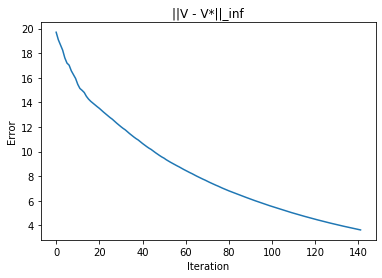

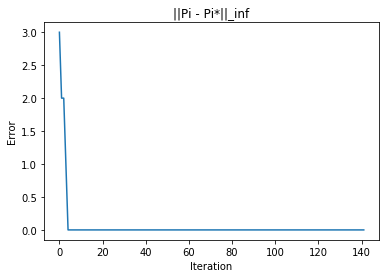

In [19]:
# Compute Value Iteration

# Retrieve the environment MDP
P = env.P
R = env.R
gamma = env.gamma
epsilon = 5e-2

# Prepare v, and storage
v = np.zeros(env.Ns)
v_all = []

pi_all = []

# iterate over the value
while True:
  
  # Compute v_k
  v, v_old = np.max(R + gamma * P.dot(v), axis=1), v
  v_all.append(v)

  # Esimate Intermediate policy
  q = R + gamma * P.dot(v)
  dpi = q.argmax(axis=1)

  pi_all.append(dpi)

  # stopping criterion 
  if np.absolute(v-v_old).max() < epsilon: 
    break

# Plot optimal policy
env.render_policy(dpi)

# You need to evaluate V* here from your optimal policy
# You have no guarantee that the last v-value is converge to the actual Vpi
pi = sparsify_policy(dpi, Na=env.Na)
Ppi = np.sum(P * np.expand_dims(pi, axis=-1), axis=1)
Rpi = np.sum(R * pi, axis=1)

v_star = np.linalg.inv( np.identity(env.Ns) - gamma*Ppi).dot(Rpi)
print("v (last):", v_all[-1])
print("v (star):", v_star)

# The difference is not exactly epsilon. We here we are comparing V*-V while the algorithm we are comparing V_new - V_old
print("epsilon: ", epsilon)
print("|v - v_star|_inf: ", np.absolute(v_all[-1]-v_star).max())

# The value function converge towards v* iteration after iteration
plot_infnorm(v_all, v_star, name="V")

# If we estimate the intermediate policies, we observe that the optimal policy is obtained earlier in the process.
# However, the value function has not yet converge. Thus ares still unaware that it is the optimal policty at iteration 4.
plot_infnorm(pi_all, dpi, name="Pi")

## Exercice: Policy Iteration (Homework)
1. Implement Policy iteration!
2. Evaluate the convergence of your estimate, i.e., plot the value $\|V_n - V^\star\|_{\infty}$
3. Evaluate the convergence of your estimate, i.e., plot the value $\|\pi_n - \pi^\star\|_{\infty}$

+-------+
|<:<:<:<|
|<:<:<:<|
|<:<:<:<|
+-------+
None


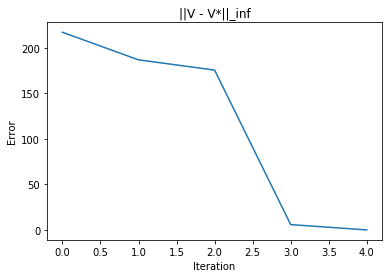

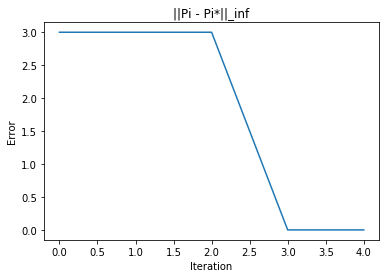

In [20]:
# Retrieve the environment MDP
P = env.P
R = env.R
gamma = env.gamma
epsilon = 5e-2

#Initialize policy
dpi = np.zeros(shape=(env.Ns,), dtype=np.int32) + 2
print(env.render_policy(dpi))

dpi = sparsify_policy(dpi, env.Na)

v_all = []
pi_all = []

epsilon = 1e-2

R_max = np.max(R)
stop = int((np.log(R_max/(epsilon)))/(np.log(1/gamma))) + 1

V_pi = np.zeros((env.Ns)) #init

while True:

  Ppi = np.sum(P * np.expand_dims(dpi, axis = -1), axis = 1)
  Rpi = np.sum(R * dpi, axis = 1)

  for i in range(stop):
    V_pi = Rpi + gamma * Ppi.dot(V_pi)
  
  v_all.append(V_pi)

  pi_old = np.argmax(dpi, axis = 1)

  Q_pi = R + gamma * P.dot(V_pi)
  pi = np.argmax(Q_pi, axis = 1)
  pi_all.append(pi)

  dpi = sparsify_policy(pi, env.Na)
  

  if np.abs(pi - pi_old).max() < epsilon : 
    break


plot_infnorm(v_all, v_all[-1], name="V")
plot_infnorm(pi_all, pi_all[-1], name="Pi")

+-------+
|<:<:<:<|
|<:<:<:<|
|<:<:<:<|
+-------+
None
+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+
None


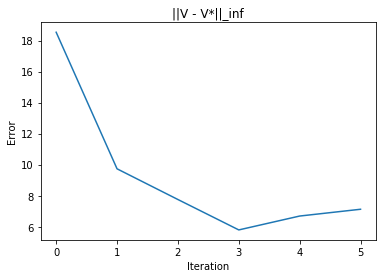

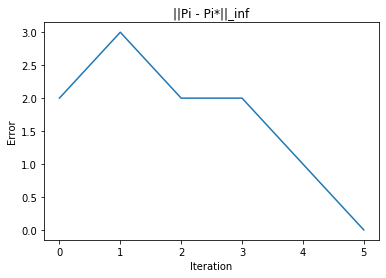

In [21]:
# Retrieve the environment MDP
P = env.P
R = env.R
gamma = env.gamma
epsilon = 5e-2

#Initialize policy
dpi = np.zeros(shape=(env.Ns,), dtype=np.int32) + 2
print(env.render_policy(dpi))
v = np.zeros(env.Ns)
v_all = []
pi_all = []

while True:

  # Policy evaluation
  v_all.append(v)
  v = (R + gamma * np.dot(P, v)).max(axis=1)

  # policy improvement
  # Estimate Intermediate policy
  pi_all.append(dpi)
  q = R + gamma * P.dot(v)
  dpi = q.argmax(axis=1)

  if np.abs(pi_all[-1] -  dpi).max() <= epsilon: break

print(env.render_policy(dpi))
plot_infnorm(v_all, v, name="V")
plot_infnorm(pi_all, dpi, name="Pi")

## Exercice: Q learning
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the cumulative sum of rewards

In [0]:
# ---------------------------
# Q-Learning
# ---------------------------
class QLearning:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self, env, gamma, learning_rate, epsilon, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.Q = np.zeros((env.Ns, env.Na))
        self.Nsa = np.ones((env.Ns, env.Na))
    
    def sample_action(self, state, greedy=False):
        epsilon = min(
            self.epsilon / math.sqrt(self.Nsa[state].min()),
            self.min_epsilon)
        
        # explore
        if not greedy and np.random.uniform(0, 1) < epsilon:
          return np.random.choice(self.env.actions)

        # exploit
        else:
          action = self.Q[state, :].argmax()
          return self.env.actions[action]
    
    def update(self, state, action, next_state, reward, done):
        alpha = self.learning_rate / math.sqrt(self.Nsa[state, action])
        
        if not done:
          max_q = self.Q[next_state, :].max()
        else:
          max_q = 0.  # We do not bootstrap further
        
        q = self.Q[state, action]
        increment = (reward + self.gamma*max_q) - q

        # Update
        self.Q[state, action] = self.Q[state, action] + alpha*increment
        self.Nsa[state, action] += 1    

In [0]:
# !pip install ipdb
# import ipdb

In [24]:
q_learning = QLearning(env, gamma=env.gamma, learning_rate=1, epsilon=0.6, min_epsilon=0.1)

# Define storage and variable
q_all = []
r_all = []
pi_all = []
max_steps = int(5e4)


# main algorithmic loop
state = env.reset()
for t in range(max_steps):
    
  # Sample the action
  action = q_learning.sample_action(state, greedy=False)
  
  # Sample the environment
  next_state, reward, done, _ = env.step(action)
  
  # Update q-function
  q_learning.update(state=state, action=action, next_state=next_state, reward=reward, done=done)

  # Store information 
  r_all.append(reward)
  q_all.append(q_learning.Q)
  pi_all.append(q_learning.Q.argmax(axis=1))
  
  state = next_state
  if done:
    state = env.reset()

dpi = q_learning.Q.argmax(axis=1)
print(env.render_policy(dpi))

+-------+
|>:>:>:>|
|^:^:>:^|
|>:>:^:^|
+-------+
None


In [25]:
state = env.reset()
env.render()
for i in range(5):
    action = q_learning.sample_action(state, greedy=True)
    state, reward, done, _ = env.step(action)
    env.render()

+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+
  (right)
+-------+
| : : :G|
| :x: : |
|S: :_: |
+-------+
  (right)
+-------+
| : : :G|
| :x:_: |
|S: : : |
+-------+
  (up)
+-------+
| : : :G|
| :x: :_|
|S: : : |
+-------+
  (right)
+-------+
| : : :G|
| :x:_: |
|S: : : |
+-------+
  (up)


In [26]:
print(q_learning.Q)

[[  2.25098376  -1.25871241   0.55091557   1.04524641]
 [  4.73025257 -16.92885844   0.90130608   2.77283894]
 [  7.79659933   3.54191453   3.28858158   5.64513535]
 [ 10.          10.          10.          10.        ]
 [-17.07301676  -3.77291878  -1.31680789   0.49239083]
 [-15.78166604 -19.26329975 -17.25930473 -15.38116718]
 [  5.6505795    1.37967081 -16.97671083   3.63212425]
 [  5.57766221   3.58975672   3.6646731    7.7849884 ]
 [ -1.14514738  -3.04532336  -3.14074971  -1.366635  ]
 [  0.67878595  -1.22884213  -3.13887592 -16.78143518]
 [  3.2354485    1.39008606  -1.02443099   3.33326837]
 [  3.45288977   2.93795282   1.37367975   5.47109075]]


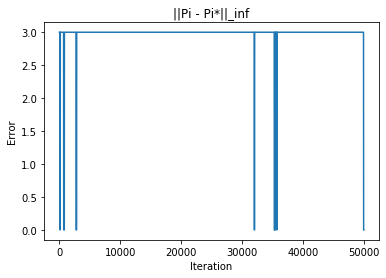

In [27]:
plot_infnorm(pi_all, pi_all[-1], name="Pi")

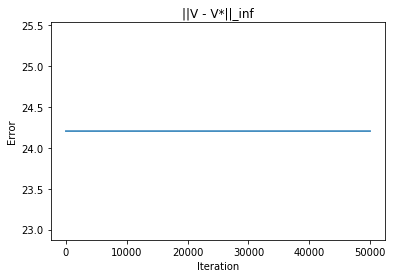

In [28]:
pi = sparsify_policy(pi_all[-1], Na=env.Na)
Ppi = np.sum(env.P * np.expand_dims(pi, axis=-1), axis=1)
Rpi = np.sum(env.R * pi, axis=1)

v_star = np.linalg.inv( np.identity(env.Ns) - gamma*Ppi).dot(Rpi)

v_all = []
for dpi_prev, q_prev in zip(pi_all, q_all):
  pi_prev = sparsify_policy(dpi_prev, Na=env.Na)
  v_prev = np.sum(pi_prev*q_prev, axis=1)
  v_all.append(v_prev)

plot_infnorm(v_all, v_star, name="V")


## Exercice: SARSA (Homework)
SARSA is another control algorithm. While Qlearning is off-policy, SARSA is on-policy.

1. Implement SARSA with softmax (Gibbs) exploration and test the convergence to $Q^\star$
2. Plot the value $\|V_n - V^\star\|_{\infty}$

In [0]:
# ---------------------------
# SARSA
# ---------------------------
class SARSA:
    """
    SARSA with deacreasing epsilon for exploration
    """
    def __init__(self, env, gamma, learning_rate, epsilon):
      # Start with a random policy
      self.env = env
      self.gamma = gamma
      self.learning_rate = learning_rate
      self.epsilon = epsilon
      # self.min_epsilon = min_epsilon
      self.Q = np.zeros((env.Ns, env.Na))
      self.Nsa = np.ones((env.Ns, env.Na))
    
    def sample_action(self, state, greedy=False):
      epsilon = self.epsilon / (math.sqrt(self.Nsa[state].min()) + 1)
      if not greedy and np.random.uniform(0, 1) < epsilon:
        return np.random.choice(self.env.actions)
      else:
        return self.env.actions[self.Q[state].argmax()]
        
    def update(self, state, action, next_state, next_action, reward):
      lr = self.learning_rate/(np.sqrt(self.Nsa[state, action]))

      if done:
        self.Q[state, action] = self.Q[state, action] + lr*(reward - self.Q[state,action])
      else:
        self.Q[state, action]=  self.Q[state, action] + lr*(reward + self.gamma*self.Q[next_state, next_action] - self.Q[state,action])
      
      self.Nsa[state,action] = self.Nsa[state,action] + 1

      # self.Nsa[state][action] += 1
      # alpha = self.learning_rate / math.sqrt(self.Nsa[state, action])
      # self.Q[state][action] +=  alpha * (reward + (self.gamma * self.Q[next_state][next_action]) - self.Q[state][action])

In [30]:
sarsa = SARSA(env, gamma=env.gamma, learning_rate=1., epsilon=1.)

# Define storage and variable
q_all = []
r_all = []
pi_all = []
max_steps = int(5e4)


# main algorithmic loop
state = env.reset()
for t in range(max_steps):
    
  # Sample the action
  action = sarsa.sample_action(state)
  
  # Sample the environment
  next_state, reward, done, info = env.step(action)
  next_action = sarsa.sample_action(next_state)
  
  # Update q-function
  sarsa.update(state, action, next_state, next_action, reward)

  # Store information 
  r_all.append(reward)
  q_all.append(sarsa.Q.copy())
  pi_all.append(sarsa.Q.argmax(axis=1))
  
  state = next_state
  if done:
    state = env.reset()

dpi = sarsa.Q.argmax(axis=1)
print(env.render_policy(dpi))

+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+
None


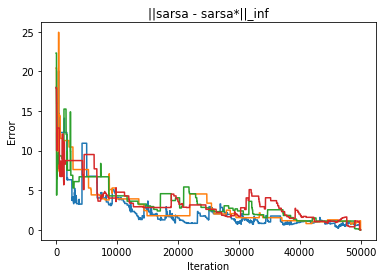

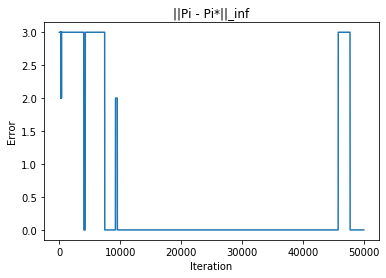

In [31]:
plot_infnorm(q_all, sarsa.Q, name="sarsa")
plot_infnorm(pi_all, dpi, name="Pi")

In [32]:
state = env.reset()
env.render()
for i in range(5):
    action = sarsa.sample_action(state, greedy=True)
    state, reward, done, _ = env.step(action)
    env.render()

+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

+-------+
| : : :G|
|_:x: : |
|S: : : |
+-------+
  (right)
+-------+
|_: : :G|
| :x: : |
|S: : : |
+-------+
  (up)
+-------+
| :_: :G|
| :x: : |
|S: : : |
+-------+
  (right)
+-------+
| : :_:G|
| :x: : |
|S: : : |
+-------+
  (right)
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+
  (right)


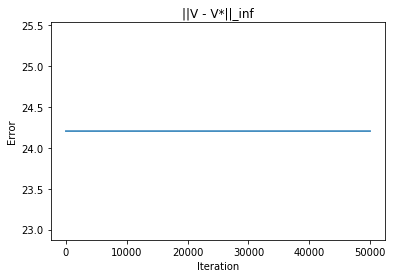

In [33]:
plot_infnorm(v_all, v_star, name="V")

<h1>About the Authors:</h1> 

<a href="https://skabongo.github.io/">Salomon Kabongo</a>, Master degree student at <a href="https://aims.ac.za/">the African Master in Machine Intelligence (AMMI, Ghana)</a> his research focused on the use machine learning technique in the field of Natural Language Processing, learn more about him [here](https://skabongo.github.io/) or https://skabongo.github.io/.

**References :** *Introduction to Reiforcement learning AMMI, course* by [Matteo Pirotta](https://teopir.github.io/), Research Scientist at Facebook AI Research, assisted by [Floian Strub](https://fstrub95.github.io/) and [Omar Darwiche Domingue](https://omardrwch.github.io/).

Copyright &copy; 2020. This notebook and its source code are released under the terms of the <a href="https://www.apache.org/licenses/LICENSE-2.0">Apache License 2.0</a>.